# 1. Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
import os
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9846887361039611733
xla_global_id: -1
]
[]


In [3]:
path = "./Dataset/"

# original data -> original
original = pd.read_csv(path+"train_A.csv")  
original

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,1,0.532754,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.517402,T050307,A_31,NaN,NaN,20153.0,24984.0,0.21,0.22,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9
2,0,0.522159,T050304,A_31,18031.0,18031.0,NaN,NaN,0.19,0.20,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
3,2,0.541429,T050304,A_31,8164.0,8164.0,NaN,NaN,0.19,0.20,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
4,1,0.526517,T050307,A_31,NaN,NaN,17014.0,21844.0,0.20,0.22,...,50.45,50.29,57.54,52.59,62.37,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2,0.548592,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,1,0.526997,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,1,0.530940,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,0,0.516681,T050304,A_31,10729.0,10729.0,NaN,NaN,0.20,0.21,...,51.30,47.66,60.00,53.75,62.58,1.0,NaN,NaN,NaN,NaN


In [24]:
dataset = []

t50304 = original[original['LINE'] =='T050304']
t50307 = original[original['LINE'] =='T050307']
t503 = pd.concat([t50304, t50307]).reset_index(drop=True)
dataset.append(t503)

t10305 = original[original['LINE'] =='T010305']
t10306 = original[original['LINE'] =='T010306']
t103 = pd.concat([t10305, t10306]).reset_index(drop=True)
dataset.append(t103)

dataset[0]

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,0,0.522159,T050304,A_31,18031.0,18031.0,NaN,NaN,0.19,0.20,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
1,2,0.541429,T050304,A_31,8164.0,8164.0,NaN,NaN,0.19,0.20,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
2,1,0.529130,T050304,A_31,21863.0,21863.0,NaN,NaN,0.20,0.21,...,58.07,55.23,51.33,56.78,63.48,1.0,NaN,NaN,NaN,NaN
3,1,0.528817,T050304,A_31,19078.0,19078.0,NaN,NaN,0.20,0.21,...,56.66,60.49,40.51,48.65,63.70,1.0,NaN,NaN,NaN,NaN
4,1,0.526868,T050304,A_31,22322.0,22322.0,NaN,NaN,0.20,0.21,...,55.91,56.14,40.27,56.86,61.74,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,0.521494,T050307,A_31,NaN,NaN,896.0,896.0,0.19,0.21,...,55.25,51.05,49.83,58.79,63.26,1.0,NaN,NaN,NaN,NaN
148,2,0.540724,T050307,A_31,NaN,NaN,17860.0,17860.0,0.19,0.20,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
149,2,0.541819,T050307,A_31,NaN,NaN,19854.0,19854.0,0.20,0.21,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
150,2,0.552100,T050307,A_31,NaN,NaN,17771.0,17771.0,0.19,0.20,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [168]:
# 1. Handling missing values  
# Preprocessed data -> processed_dataset
processed_dataset = []

for data in dataset: 
    data = data.copy().fillna(0)
    processed_dataset.append(data)

In [169]:
# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
for i, data in enumerate(processed_dataset):
    # Get the counts of unique values per column
    value_counts = data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

    # Filter columns with only one unique value
    unique_columns = value_counts[value_counts >= 2].index
    duplicated_columns = value_counts[value_counts <= 1].index

    data = data.drop(duplicated_columns, axis=1)
    processed_dataset[i] =  data

In [170]:
# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
for i, data in enumerate(processed_dataset):
    df = data.iloc[:,4:].T.drop_duplicates(keep='first').T
    data = pd.concat([data.iloc[:,:4], df], axis=1)
    processed_dataset[i] = data

In [171]:
# 4. Regularization -> robust scaler
rs = RobustScaler()
ss = StandardScaler()

for i, data in enumerate(processed_dataset):
    data.iloc[:, 4:] = rs.fit_transform(data.iloc[:, 4:])
    processed_dataset[i] = data

In [172]:
# 5. Label Encoding 
le = LabelEncoder() 
le.fit(original['LINE'])
print(le.classes_)

for i, data in enumerate(processed_dataset):
    data['LINE'] = le.transform(data['LINE'])
    data['PRODUCT_CODE'] = data['PRODUCT_CODE'].replace({'A_31': 0})
    processed_dataset[i] = data

['T010305' 'T010306' 'T050304' 'T050307']


In [173]:
# # 6. Multicollinearity 
# from collinearity import SelectNonCollinear

# for i, data in enumerate(processed_dataset):
#     nonX_data = data.iloc[:, :4]
#     X_data = data.iloc[:, 4:]
    
#     selector = SelectNonCollinear(0.9)
#     selector.fit(X_data.values)
#     mask = selector.get_support() # True or False

#     selected_df = pd.DataFrame(X_data.loc[:,mask])
#     data = pd.concat([nonX_data, selected_df], axis=1)
#     processed_dataset[i] =  data

# 3. Data Split

A data 
- 294 (0: 130, 1: 164)

t103
- 0: 79
- 1: (24+39) = 63

t503 
- 0: 51
- 1: (55+46) = 101

Test Data (147개) 
- 1: 82개 (t103/t503/31/51)
- 0: 65개 (t103/t503/39/26)

Train Data (147개)
- 1: 82개 (t103/t503/32/50)
- 0: 65개 (t103/t503/40/25)

Train Normal Data (130개)
- 0: 130개 (t103/t503/79/51)

In [174]:
input_dataset = processed_dataset.copy()
test_dataset = []
train_dataset = []
normal_dataset = []
abnormal_dataset = []

for i, data in enumerate(input_dataset): 
    # Divide processed_data to abnormal and normal 
    normal_data = data[data['Y_Class']==1]
    normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0

    undershoot = data[data['Y_Class']==0]
    overshoot = data[data['Y_Class']==2]
    abnormal_data = pd.concat([undershoot, overshoot])
    abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1 

    normal_dataset.append(normal_data)
    abnormal_dataset.append(abnormal_data)
    print(str(i), '-> Normal Data:', normal_data.shape, ', Abnormal Data:', abnormal_data.shape)

    # Create test data (normal 65, abnormal 82 = 147)
    test_normal = normal_data.sample(n = len(normal_data)//2, random_state = SEED)
    test_abnormal = abnormal_data.sample(n = len(abnormal_data)//2, random_state = SEED) 
    test_data = pd.concat([test_normal, test_abnormal])
    
    test_dataset.append(test_data)
    print(str(i), '-> Test Data:', test_data.shape)

    # Create train data based on normal data (638)
    train_normal = normal_data.drop(test_normal.index)
    train_abnormal = abnormal_data.drop(test_abnormal.index)
    train_data = pd.concat([train_normal, train_abnormal])
    
    train_dataset.append(train_data)
    print(str(i), '-> Train Data:', train_data.shape, '\n')

0 -> Normal Data: (51, 1094) , Abnormal Data: (101, 1094)
0 -> Test Data: (75, 1094)
0 -> Train Data: (77, 1094) 

1 -> Normal Data: (79, 597) , Abnormal Data: (63, 597)
1 -> Test Data: (70, 597)
1 -> Train Data: (72, 597) 



# 4. Regression for  Y_Quality 

In [175]:
best_models = []

In [184]:
from pycaret.regression import *
from time import time

# Setup Environment  

cat_cols = ['LINE', 'PRODUCT_CODE', 'Y_Class']
FOLD = 5
NUMBER = 1

reg = setup(data = train_dataset[NUMBER], 
            train_size = 0.8,
            test_data = test_dataset[NUMBER],
            target = 'Y_Quality',
            ignore_features = cat_cols,
            #preprocess = True,  # default True
            feature_selection = True,
            n_features_to_select = 0.2, # default 0.2
            fold=FOLD, # defualt 10 
            fold_shuffle=True,
            use_gpu = True,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,Y_Quality
2,Target type,Regression
3,Original data shape,"(142, 597)"
4,Transformed data shape,"(142, 119)"
5,Transformed train set shape,"(72, 119)"
6,Transformed test set shape,"(70, 119)"
7,Ignore features,3
8,Numeric features,593
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [185]:
# EG, Cat, GBR, LGBM, XGB
top5 = compare_models(sort='r2', n_select=5, fold=FOLD, exclude=['lar', 'par', 'huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0045,0.0000,0.0059,0.5473,0.0038,0.0084,0.1900
br,Bayesian Ridge,0.0043,0.0000,0.0058,0.5171,0.0038,0.0080,0.0740
omp,Orthogonal Matching Pursuit,0.0050,0.0000,0.0064,0.4519,0.0042,0.0094,0.0740
catboost,CatBoost Regressor,0.0049,0.0000,0.0066,0.4084,0.0043,0.0092,10.7420
ada,AdaBoost Regressor,0.0054,0.0001,0.0072,0.3389,0.0047,0.0102,0.1440
rf,Random Forest Regressor,0.0057,0.0001,0.0072,0.3299,0.0047,0.0107,0.2360
gbr,Gradient Boosting Regressor,0.0055,0.0001,0.0074,0.2839,0.0048,0.0103,0.2040
knn,K Neighbors Regressor,0.0056,0.0001,0.0077,0.2752,0.0050,0.0106,0.0800
ridge,Ridge Regression,0.0055,0.0001,0.0071,0.2681,0.0046,0.0104,0.0740
xgboost,Extreme Gradient Boosting,0.0056,0.0001,0.0078,0.1869,0.0051,0.0105,0.3920


In [186]:
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
    # tuned_model = tune_model(model, fold=5, optimize='r2', choose_better=True)
    total_models.append(model)
    # tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0040,0.0000,0.0054,0.2305,0.0036,0.0077
1,0.0044,0.0000,0.0057,0.6051,0.0037,0.0083
2,0.0035,0.0000,0.0043,0.7049,0.0028,0.0066
3,0.0052,0.0000,0.0068,0.6280,0.0044,0.0097
4,0.0052,0.0001,0.0071,0.5680,0.0047,0.0100
Mean,0.0045,0.0000,0.0059,0.5473,0.0038,0.0084
Std,0.0007,0.0000,0.0010,0.1646,0.0007,0.0013


CELL RUN TIME:  1.3285870552062988
BayesianRidge()


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0046,0.0000,0.0061,0.0452,0.0040,0.0088
1,0.0035,0.0000,0.0049,0.7119,0.0032,0.0066
2,0.0036,0.0000,0.0056,0.5011,0.0036,0.0068
3,0.0055,0.0001,0.0072,0.5903,0.0047,0.0102
4,0.0040,0.0000,0.0056,0.7369,0.0036,0.0077
Mean,0.0043,0.0000,0.0058,0.5171,0.0038,0.0080
Std,0.0007,0.0000,0.0008,0.2508,0.0005,0.0013


CELL RUN TIME:  0.6620314121246338
OrthogonalMatchingPursuit()


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0048,0.0000,0.0057,0.1448,0.0038,0.0091
1,0.0050,0.0000,0.0064,0.4992,0.0042,0.0093
2,0.0043,0.0000,0.0054,0.5282,0.0035,0.0081
3,0.0071,0.0001,0.0092,0.3223,0.0060,0.0131
4,0.0039,0.0000,0.0052,0.7652,0.0034,0.0074
Mean,0.0050,0.0000,0.0064,0.4519,0.0042,0.0094
Std,0.0011,0.0000,0.0015,0.2085,0.0009,0.0020


CELL RUN TIME:  0.7089970111846924


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0050,0.0000,0.0066,-0.1177,0.0043,0.0096
1,0.0035,0.0000,0.0055,0.6298,0.0036,0.0065
2,0.0037,0.0000,0.0052,0.5631,0.0034,0.0068
3,0.0070,0.0001,0.0089,0.3640,0.0058,0.0130
4,0.0053,0.0000,0.0068,0.6029,0.0045,0.0101
Mean,0.0049,0.0000,0.0066,0.4084,0.0043,0.0092
Std,0.0013,0.0000,0.0013,0.2791,0.0009,0.0024


CELL RUN TIME:  64.7309341430664
AdaBoostRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0045,0.0000,0.0060,0.0773,0.0039,0.0085
1,0.0050,0.0001,0.0073,0.3581,0.0047,0.0094
2,0.0043,0.0000,0.0052,0.5707,0.0034,0.0080
3,0.0079,0.0001,0.0098,0.2336,0.0064,0.0146
4,0.0054,0.0001,0.0080,0.4547,0.0053,0.0105
Mean,0.0054,0.0001,0.0072,0.3389,0.0047,0.0102
Std,0.0013,0.0000,0.0016,0.1715,0.0011,0.0024


CELL RUN TIME:  1.11700439453125


In [187]:
blender_top5 = blend_models(estimator_list=total_models)
# blender_tuned5 = blend_models(estimator_list=tuned_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0042,0.0000,0.0054,0.2506,0.0035,0.0079
1,0.0039,0.0000,0.0054,0.6499,0.0035,0.0072
2,0.0036,0.0000,0.0048,0.6356,0.0031,0.0068
3,0.0059,0.0001,0.0079,0.4988,0.0052,0.0110
4,0.0042,0.0000,0.0057,0.7239,0.0037,0.0081
Mean,0.0044,0.0000,0.0058,0.5517,0.0038,0.0082
Std,0.0008,0.0000,0.0011,0.1672,0.0007,0.0015


In [188]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model)
    total_predictions.append(pred)
print() 

# for tuned models 
# for model in tuned_models: 
#     prediction = predict_model(model)
# print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5)
print() 

# for blended model (tuned)
# pred_blend_tuned5 = predict_model(blender_tuned5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0035,0.0000,0.0046,0.7402,0.0030,0.0065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0047,0.0000,0.0058,0.5891,0.0038,0.0089


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.0053,0.0000,0.0068,0.4488,0.0044,0.0100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0037,0.0000,0.0048,0.7162,0.0032,0.0068


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0036,0.0000,0.0048,0.7251,0.0031,0.0068


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0035,0.0000,0.0045,0.7538,0.0029,0.0065


In [189]:
best_model = total_models[0]
best_models.append(best_model)
best_model

ExtraTreesRegressor(n_jobs=-1, random_state=42)

In [190]:
test_data = test_dataset[NUMBER] # NUMBER

pred_yQuality = predict_model(best_model)
pred_yQuality = pd.DataFrame(pred_yQuality['prediction_label'])

test_data = pd.concat([test_data, pred_yQuality], axis=1)
test_dataset[NUMBER] = test_data
test_data

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0035,0.0000,0.0046,0.7402,0.0030,0.0065


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_246,X_247,X_248,X_250,X_251,X_253,...,X_1697,X_2044,X_2045,X_2046,X_2047,X_2048,X_2049,X_2050,X_2051,prediction_label
52,0,0.528856,0,0,0.0,-0.25,-0.048518,0.0,0.150289,0.0,...,-0.400000,-0.318933,-0.318933,-0.318933,-0.318297,0.950916,0.950916,4.593536,-0.397661,0.526747
0,0,0.532754,0,0,0.0,-0.25,-0.048518,0.0,1.109827,-1.0,...,1.200000,0.814485,0.814485,0.814485,0.813850,-0.008426,-0.008426,0.133203,0.252297,0.529891
37,0,0.530341,0,0,0.0,0.75,-0.048518,0.0,0.462428,-1.0,...,1.200000,1.327827,1.329098,1.329098,1.328463,0.071203,0.071203,0.503428,0.568087,0.530633
53,0,0.530514,0,0,1.0,-0.50,-0.048518,0.0,0.485549,-1.0,...,0.266667,0.016518,0.016518,0.016518,0.015883,-0.127238,-0.127238,-0.419197,-0.218881,0.528625
30,0,0.534376,0,0,1.0,-0.25,-0.048518,0.0,1.560694,-1.0,...,-0.066667,-0.607370,-0.607370,-0.607370,-0.606734,0.908363,0.908363,4.395690,-0.566416,0.533588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,0.545925,1,0,1.0,0.75,1.784367,0.0,0.000000,0.0,...,-0.333333,-0.689962,-0.689962,-0.689962,-0.689327,0.898673,0.898673,0.001959,3.104428,0.540919
114,1,0.536616,1,0,1.0,0.25,1.654987,0.0,0.000000,0.0,...,-0.400000,-0.743329,-0.743329,-0.743329,-0.742694,0.889825,0.889825,-0.039177,3.069340,0.536313
28,1,0.555514,0,0,1.0,-0.75,-0.048518,0.0,1.317919,-1.0,...,0.533333,-0.689962,-0.689962,-0.691233,-0.690597,0.898252,0.898252,0.000000,3.102757,0.546097
24,1,0.536433,0,0,0.0,-0.50,-0.048518,0.0,1.930636,-1.0,...,-0.333333,-0.470140,-0.470140,-0.470140,-0.469504,0.931536,0.931536,4.503428,-0.474520,0.533097


# 5. Anomaly Detection for Y_Class based on Y_Quality 

In [191]:
# 130 X 4
normal_data = pd.concat([normal_dataset[0].iloc[:,:4], normal_dataset[1].iloc[:,:4]], axis=0).reset_index(drop=True)
print(normal_data.Y_Class.value_counts())
print(normal_data.shape)

0    130
Name: Y_Class, dtype: int64
(130, 4)


In [192]:
# 145 X 4 
cat_cols = ['prediction_label', 'LINE', 'PRODUCT_CODE', 'Y_Class']
test_data = pd.concat([test_dataset[0][cat_cols], test_dataset[1][cat_cols]])
print(test_data.Y_Class.value_counts())
print(test_data.shape)

1    81
0    64
Name: Y_Class, dtype: int64
(145, 4)


In [193]:
from pycaret.anomaly import *
from time import time

# Setup Environment  
anomaly = setup(data = pd.DataFrame(normal_data[['Y_Quality', 'LINE', 'PRODUCT_CODE']]),
                preprocess = False,
                use_gpu = True,
                session_id = SEED)

,Description,Value
0,Session id,42
1,Original data shape,"(130, 3)"
2,Transformed data shape,"(130, 3)"
3,Numeric features,3


In [194]:
# IForest, KNN, SVM, PCA, LoF, total five models  
iforest = create_model('iforest')
knn = create_model('knn')
svm = create_model('svm')
pca = create_model('pca')
lof = create_model('lof')

total_ads = [iforest, knn,  svm, pca, lof]

In [195]:
predictions_ads = []

for model in total_ads:
    pred = predict_model(model, data=test_data[['prediction_label', 'LINE', 'PRODUCT_CODE']])
    predictions_ads.append(pred)

predictions_ads[0].head()

,prediction_label,LINE,PRODUCT_CODE,Anomaly,Anomaly_Score
119,0.526348,3,0,0,-0.023502
110,0.524860,3,0,1,0.036560
131,0.534412,3,0,1,0.033516
30,0.532343,2,0,0,-0.094566
55,0.527562,2,0,0,-0.129553


In [196]:
def confusionMatrix(test_pred):
    test_y = test_data['Y_Class']
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))

accuracy:  0.7103448275862069
recall:  0.593
precision:  0.842
f1-score:  0.696


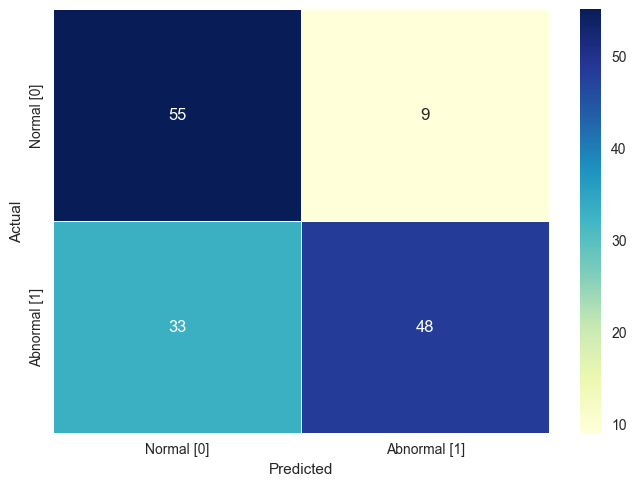

In [197]:
confusionMatrix(predictions_ads[0]['Anomaly'])

accuracy:  0.7655172413793103
recall:  0.654
precision:  0.898
f1-score:  0.757


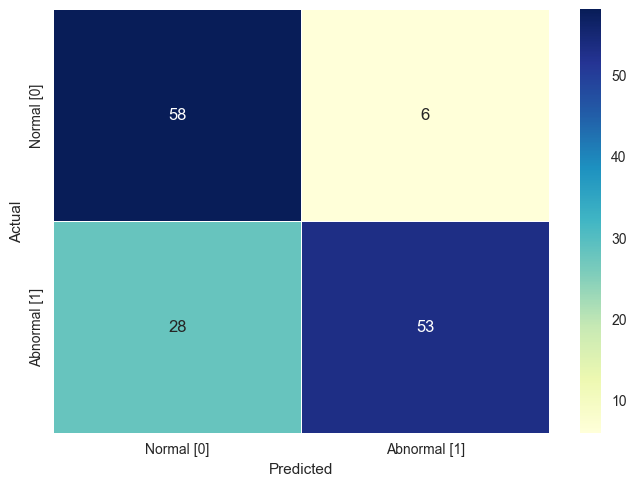

In [198]:
confusionMatrix(predictions_ads[1]['Anomaly'])

accuracy:  0.5724137931034483
recall:  0.309
precision:  0.806
f1-score:  0.446


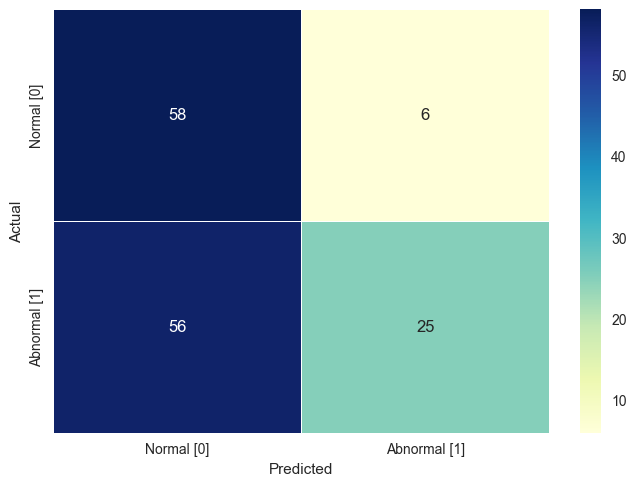

In [199]:
confusionMatrix(predictions_ads[2]['Anomaly'])

accuracy:  0.4413793103448276
recall:  0.0
precision:  0.0
f1-score:  0.0


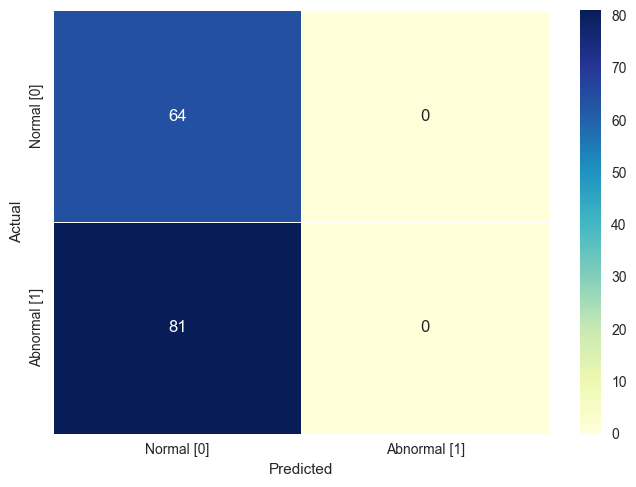

In [200]:
confusionMatrix(predictions_ads[3]['Anomaly'])

accuracy:  0.4413793103448276
recall:  0.0
precision:  0.0
f1-score:  0.0


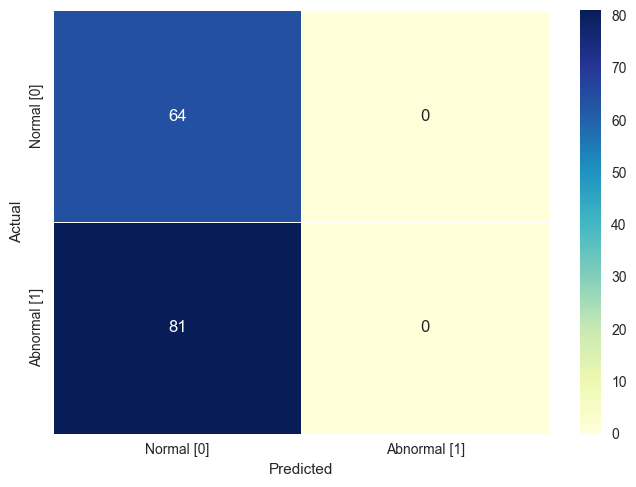

In [201]:
confusionMatrix(predictions_ads[4]['Anomaly'])

In [202]:
test_data['prediction'] = 1
normal = test_data[test_data['prediction_label']>=0.52]
normal = normal[normal['prediction_label']<=0.53]
normal['prediction'] =0
test_data = test_data.drop(normal.index)
test_data = pd.concat([test_data, normal])
test_data

,prediction_label,LINE,PRODUCT_CODE,Y_Class,prediction
131,0.534412,3,0,0,1
30,0.532343,2,0,0,1
35,0.531730,2,0,0,1
24,0.532141,2,0,0,1
1,0.536890,2,0,1,1
...,...,...,...,...,...
34,0.528340,0,0,1,0
82,0.524799,1,0,1,0
26,0.524223,0,0,1,0
31,0.528671,0,0,1,0


accuracy:  0.5901639344262295
recall:  0.485
precision:  0.688
f1-score:  0.569


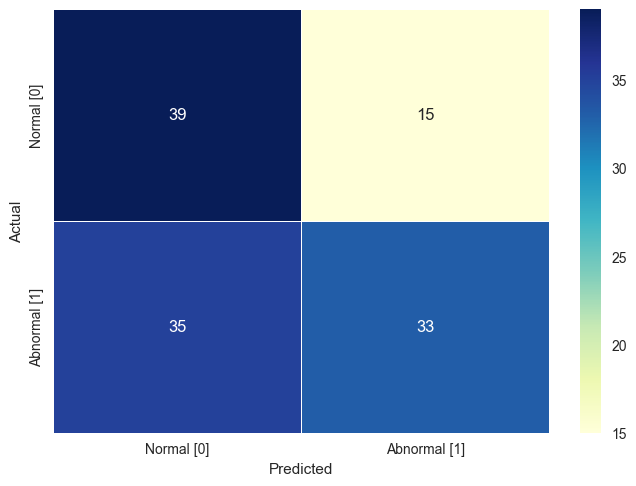

In [203]:
def confusionMatrix(test_pred):
    test_y = test_data['Y_Class']
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))
confusionMatrix(test_data['prediction'])

# 6. Plotting

In [ ]:
plot_model(best_model, plot='residuals')

In [ ]:
evaluate_model(best_model)

In [ ]:
interpret_model(total_models[CHECK], plot='summary')

In [ ]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[CHECK]['Y_Quality'].to_numpy()
pred_y = total_predictions[CHECK]['prediction_label'].to_numpy()
graph(pred_y, true_y)